# hash functions

In [8]:
import os
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import time
import timeit


### hash functions

#### Topic today: how different hash functions affect the computation time ?

last week we've talked about how hashtable can still work when collisions happened, But it still is something we want to avoid. and today we'll talk about how to avoid collisions, using different hash functions.

- First, we will set up the data we need

- secondly, we will hash some real life textual data, into our hashtable, and see the collisions distribution. Then, we will do the same thing, but with different hash functions, and see how it affects the collisions distribution.

- lastly, we will simulate the hash function computation time, and see how different hash functions affect the computation time.

## STEP 1: data preparation

In [9]:
def filelist(root: str) -> list[str]:
    """Return a fully-qualified list of filenames under root directory
    traversing subdirectories recursively and return all the paths of files
    """
    return [os.path.join(root, f) for root, _, files in os.walk(root) for f in files]


def get_text(fileName: str) -> str:
    f = open(fileName, encoding='latin-1')
    s = f.read()
    f.close()
    return s

def words(text: str) -> list[str]:
    """
    Given a string, return a list of words normalized as follows.
    Split the string to make words first by using regex compile() function
    and string.punctuation + '0-9\\r\\t\\n]' to replace all those
    char with a space character.
    Split on space to get word list.
    Ignore words < 3 char long.
    Lowercase all words
    """
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    # delete stuff but leave at least a space to avoid clumping together
    nopunct = regex.sub(" ", text)
    words = nopunct.split(" ")
    words = [w for w in words if len(w) > 2]  # ignore a, an, to, at, be, ...
    words = [w.lower() for w in words]
    # print words
    return words

def text_data_set_up(path: str) -> list[str]:
    files = filelist(path)
    texts = [get_text(f) for f in files]
    word_list = [words(t) for t in texts]
    word_list = [w for wl in word_list for w in wl]

    return list(set(word_list))



In [10]:
texts = text_data_set_up('./slate')
len(texts)
texts[:10]

['compress',
 'zombie',
 'admittedly',
 'kathapollitt',
 'paramilitary',
 'combustibility',
 'syndey',
 'inchoate',
 'mpotence',
 'marshmallow']

## STEP 2 : comparing the hash functions in terms of collisions distribution

In [11]:
def bad_hash(word: str, size: int = 26*26) -> int:
    a = ord(word[0]) - 97
    b = ord(word[1]) - 97
    
    return (a * 26 + b) % size


def good_hash(key, size: int = 26*26) -> int:
    key = str(key)
    h = 0
    for i in key:
        h += 31* h + ord(i)

    return  h % size



In [12]:
good_hashes = [good_hash(w) for w in texts]
good_hash_counter = Counter(good_hashes)


hashes = [bad_hash(w) for w in texts]
bad_hash_counter = Counter(hashes)

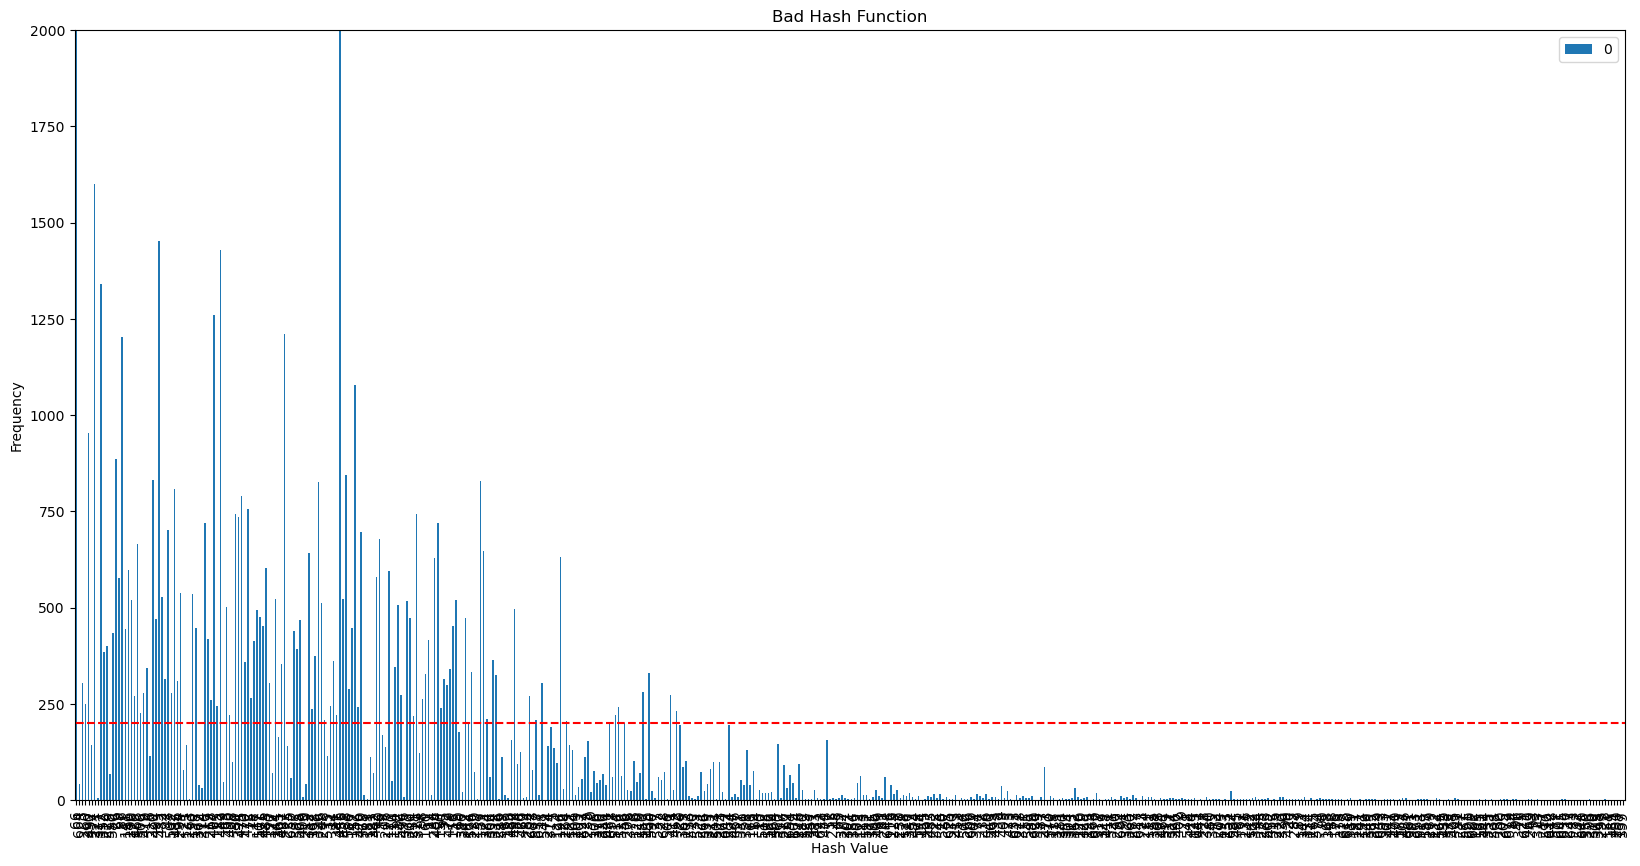

In [13]:

df = pd.DataFrame.from_dict(bad_hash_counter, orient='index')
fig, ax = plt.subplots()
df.plot(kind='bar', ax = ax, figsize=(20, 10), xlim=(0, 26*26), ylim=(0, 2000))
df_g = pd.DataFrame.from_dict(good_hash_counter, orient='index')
df_g.sort_values(by=0, ascending=False).tail(10)
ax.set_xlabel('Hash Value')
ax.set_ylabel('Frequency')
ax.set_title('Bad Hash Function')
ax.hlines(200, 0, 26*26, colors='r', linestyles='dashed')

<AxesSubplot:title={'center':'Bad Hash Function'}, xlabel='Hash Value', ylabel='Frequency'>

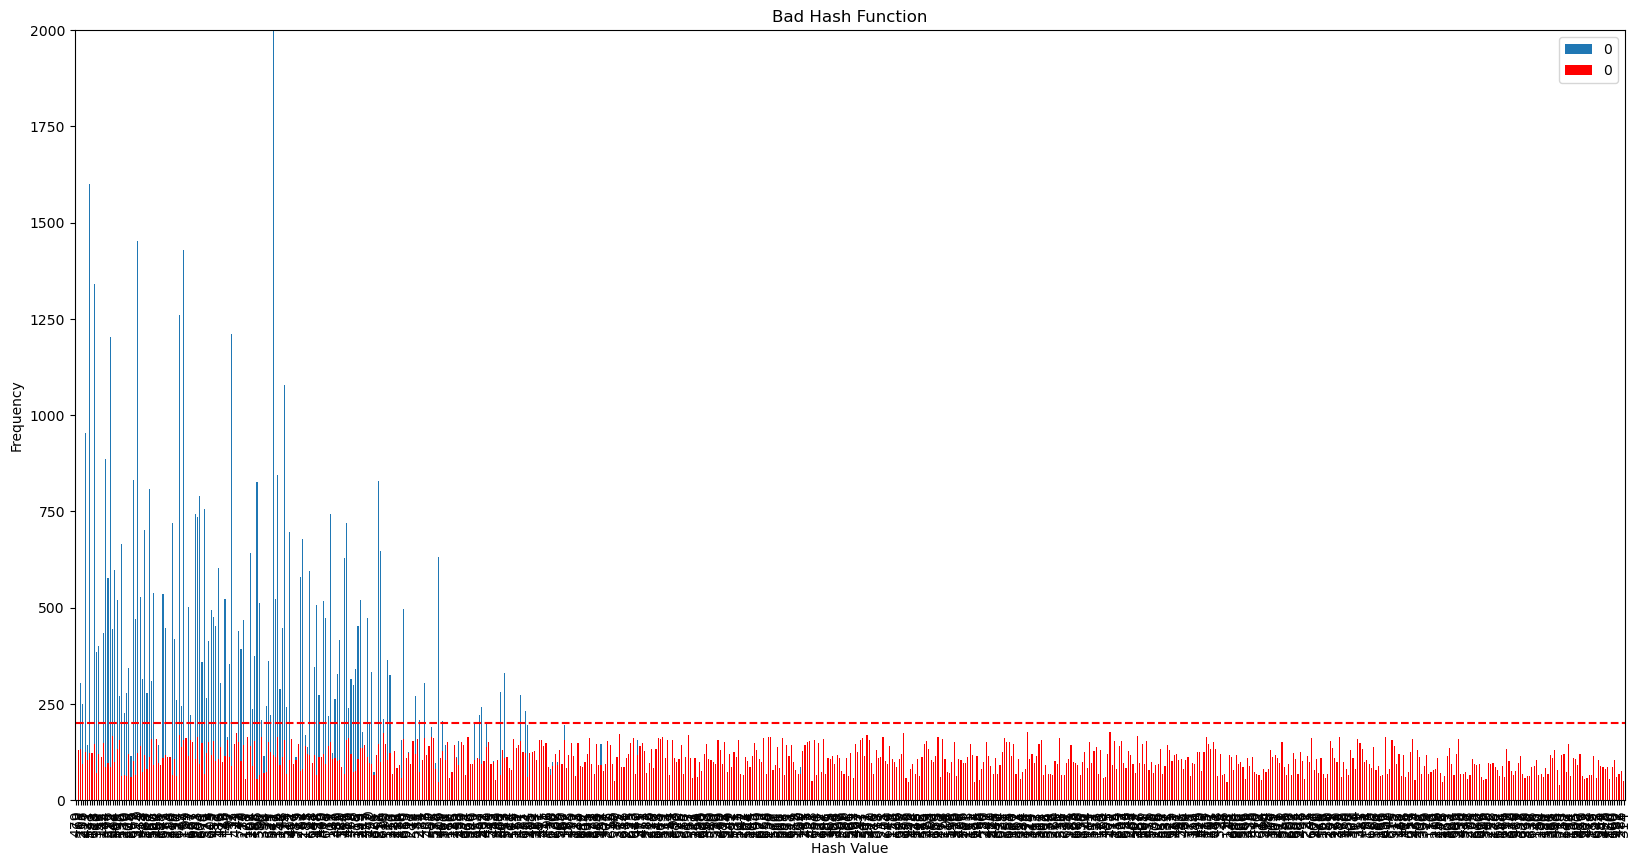

In [14]:
fig, ax = plt.subplots()
df.plot(kind='bar', ax = ax, figsize=(20, 10), xlim=(0, 26*26), ylim=(0, 2000))
ax.set_xlabel('Hash Value')
ax.set_ylabel('Frequency')
ax.set_title('Bad Hash Function')
ax.hlines(200, 0, 26*26, colors='r', linestyles='dashed')
df_g.plot(kind='bar',ax = ax, figsize=(20, 10), xlim=(0, 26*26), color = 'r')

<AxesSubplot:>

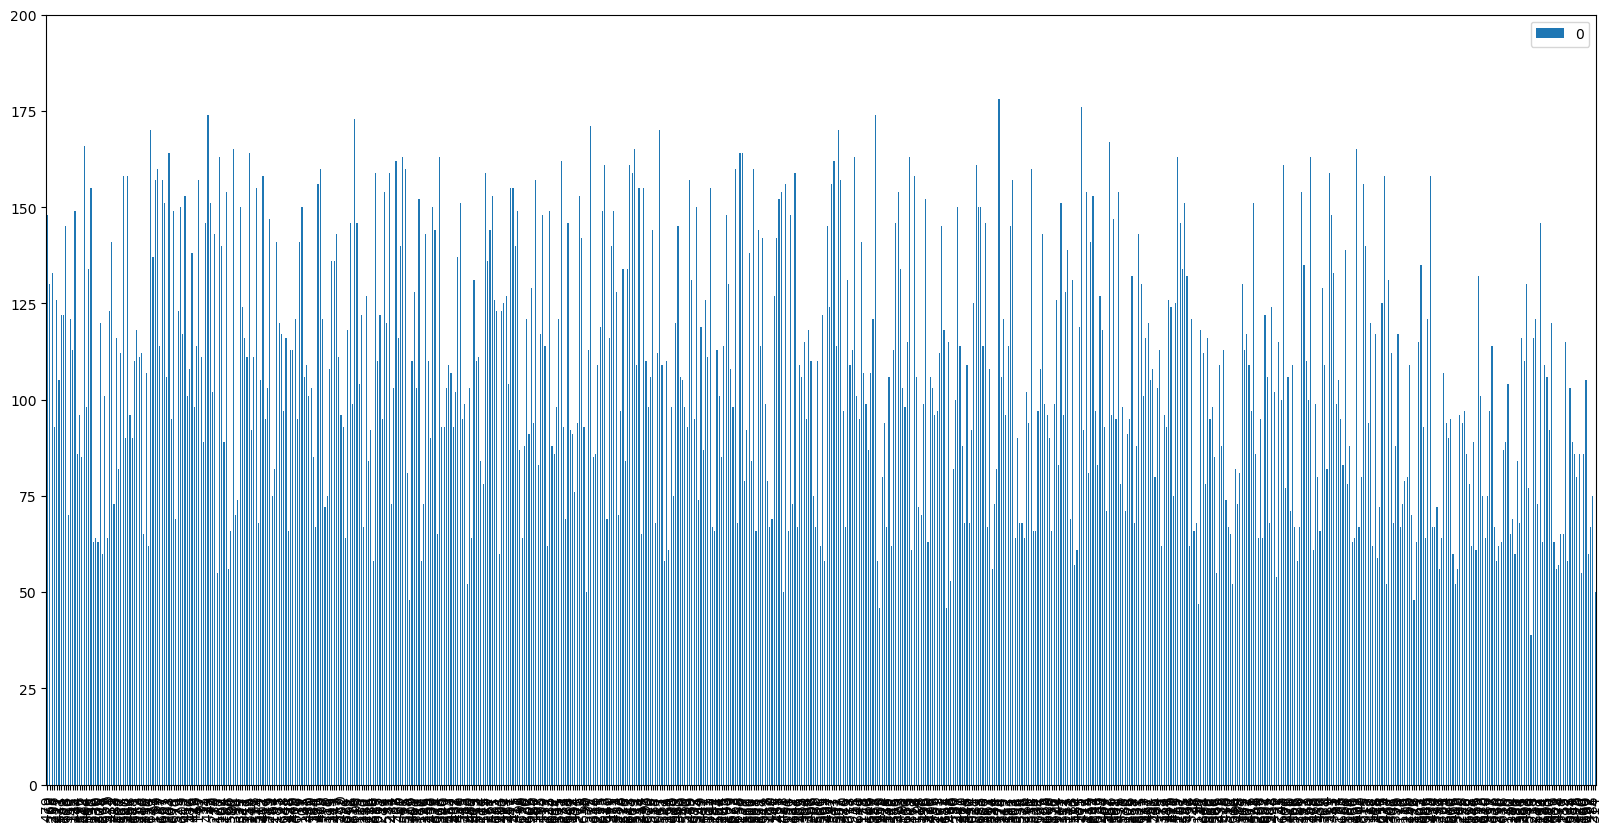

In [15]:

df_g.plot(kind='bar', figsize=(20, 10), xlim=(0, 26*26), ylim=(0, 200))

## STEP 3: comparing the hash functions in terms of computation time

### 3-1 Hash table class

In [16]:
from typing import Callable


class Hashtable:
    def __init__(self, hash_func: Callable[[str,int],int], size: int) -> None:
        self.size = size
        self.table = [[] for _ in range(size)]
        self._hash = hash_func

    def __setitem__(self, key: str, value:str) -> None:
        index = self._hash(key, self.size)
        self.table[index].append((key, value))

    def __getitem__(self, key: str) -> str:
        index = self._hash(key, self.size)

        for k, v in self.table[index][::-1]:
            if k == key:
                return v

    def __delitem__(self, key: str) -> None:
        index = self._hash(key, self.size)

        for k, v in self.table[index]:
            if k == key:
                self.table[index].remove((k, v))
    

In [17]:

bad_dict = Hashtable(bad_hash, 26*26)
good_dict = Hashtable(good_hash, 26*26)


### 3-2 timer function & testing tasks set up 

In [18]:
def timer(f):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        return result, end - start
    return wrapper
  


@timer
def test_speed(my_dict: Hashtable, word_list: list[str]) -> None:
    
    for i, w in enumerate(word_list):
        my_dict[w] = i

    for w in word_list:
        x = my_dict[w]

    for w in word_list:
        del my_dict[w]

###  3-3 run test

In [21]:
_ , good_time = test_speed(good_dict, texts)
_ , bad_time = test_speed(bad_dict, texts)

In [20]:
print(
f'''
{bad_time=} seconds

{good_time=} seconds''')


bad_time=2.6989667415618896 seconds

good_time=0.6151101589202881 seconds


In [30]:

def fib(n: int) -> int:
    if n <= 1:
        return n
    else:
        return fib(n-1) + fib(n-2)

In [35]:
fib(35)

9227465

In [36]:

from functools import lru_cache

@lru_cache(maxsize=128)
def fib(n: int) -> int:
    if n <= 1:
        return n
    else:
        return fib(n-1) + fib(n-2)
        

In [39]:

fib(1000)

43466557686937456435688527675040625802564660517371780402481729089536555417949051890403879840079255169295922593080322634775209689623239873322471161642996440906533187938298969649928516003704476137795166849228875

# How do we enjoy the speed of hash functions in our daily python work?

### case 1


In [1]:
# decorator to cache a function result


def cache(hash_table: dict):
    def decorator(f):
        def wrapper(*args, **kwargs):

            # whenever a function is called, the first thing we do is to 
            # check if there is a record of the specific input in the cache
            key = str(args) + str(kwargs)
            

            # if there is a record, return the result
            if key in hash_table:
                return hash_table[key]
            
            # if there is no record in hash table, we call the function and store the result
            else:
                result = f(*args, **kwargs)
                hash_table[key] = result
                return result
        return wrapper
    return decorator


def slow_fib(n: int) -> int:
    if n <= 1:
        return n
    else:
        return slow_fib(n-1) + slow_fib(n-2)

slow_fib(36)

14930352

In [2]:

hash = {}


@cache(hash)
def fib(n: int) -> int:
    if n <= 1:
        return n
    else:
        return fib(n-1) + fib(n-2)

fib(1000)

43466557686937456435688527675040625802564660517371780402481729089536555417949051890403879840079255169295922593080322634775209689623239873322471161642996440906533187938298969649928516003704476137795166849228875

In [3]:
hash

{'(1,){}': 1,
 '(0,){}': 0,
 '(2,){}': 1,
 '(3,){}': 2,
 '(4,){}': 3,
 '(5,){}': 5,
 '(6,){}': 8,
 '(7,){}': 13,
 '(8,){}': 21,
 '(9,){}': 34,
 '(10,){}': 55,
 '(11,){}': 89,
 '(12,){}': 144,
 '(13,){}': 233,
 '(14,){}': 377,
 '(15,){}': 610,
 '(16,){}': 987,
 '(17,){}': 1597,
 '(18,){}': 2584,
 '(19,){}': 4181,
 '(20,){}': 6765,
 '(21,){}': 10946,
 '(22,){}': 17711,
 '(23,){}': 28657,
 '(24,){}': 46368,
 '(25,){}': 75025,
 '(26,){}': 121393,
 '(27,){}': 196418,
 '(28,){}': 317811,
 '(29,){}': 514229,
 '(30,){}': 832040,
 '(31,){}': 1346269,
 '(32,){}': 2178309,
 '(33,){}': 3524578,
 '(34,){}': 5702887,
 '(35,){}': 9227465,
 '(36,){}': 14930352,
 '(37,){}': 24157817,
 '(38,){}': 39088169,
 '(39,){}': 63245986,
 '(40,){}': 102334155,
 '(41,){}': 165580141,
 '(42,){}': 267914296,
 '(43,){}': 433494437,
 '(44,){}': 701408733,
 '(45,){}': 1134903170,
 '(46,){}': 1836311903,
 '(47,){}': 2971215073,
 '(48,){}': 4807526976,
 '(49,){}': 7778742049,
 '(50,){}': 12586269025,
 '(51,){}': 20365011

In [4]:
# in python we don't have to define our own cache decorator, we can just do this


from functools import cache


@cache
def fib(n: int) -> int:
    if n <= 1:
        return n
    else:
        return fib(n-1) + fib(n-2)

fib(1000)

43466557686937456435688527675040625802564660517371780402481729089536555417949051890403879840079255169295922593080322634775209689623239873322471161642996440906533187938298969649928516003704476137795166849228875